In [5]:
import pandas as pd
import numpy as np
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib.lines as mlines

entities=pd.read_csv("../data/extract_data/metakg_entities.csv")
triples=pd.read_csv("../data/extract_data/metakg_triples.csv")
hmdb_list=['hmdb_id:HMDB0001308','hmdb_id:HMDB0062800','hmdb_id:HMDB0001341','hmdb_id:HMDB0000208','hmdb_id:HMDB0062424','hmdb_id:HMDB0014559','hmdb_id:HMDB0000168','hmdb_id:HMDB0000191','hmdb_id:HMDB0000538','hmdb_id:HMDB0000562','hmdb_id:HMDB0000082','hmdb_id:HMDB0001532','hmdb_id:HMDB0000998','hmdb_id:HMDB0000012','hmdb_id:HMDB0001112','hmdb_id:HMDB0001473','hmdb_id:HMDB0001068','hmdb_id:HMDB0001342','hmdb_id:HMDB0001409','hmdb_id:HMDB0001058','hmdb_id:HMDB0001049','hmdb_id:HMDB0001201','hmdb_id:HMDB0008327','hmdb_id:HMDB0001397','hmdb_id:HMDB0003379','hmdb_id:HMDB0015536','hmdb_id:HMDB0000172','hmdb_id:HMDB0000156','hmdb_id:HMDB0002108','hmdb_id:HMDB0001138','hmdb_id:HMDB0006029','hmdb_id:HMDB0011745','hmdb_id:HMDB0001487','hmdb_id:HMDB0000217','hmdb_id:HMDB0000828','hmdb_id:HMDB0250791','hmdb_id:HMDB0001489','hmdb_id:HMDB0000618','hmdb_id:HMDB0029418','hmdb_id:HMDB0060274','hmdb_id:HMDB0000251','hmdb_id:HMDB0000295','hmdb_id:HMDB0000286','hmdb_id:HMDB0000290','hmdb_id:HMDB0000285',"hmdb_id:HMDB0000094","hmdb_id:HMDB0001112","hmdb_id:HMDB0001068","hmdb_id:HMDB0001058","hmdb_id:HMDB0000172","hmdb_id:HMDB0001138","hmdb_id:HMDB0000812","hmdb_id:HMDB0006029","hmdb_id:HMDB0001015","hmdb_id:HMDB000148","hmdb_id:HMDB0000618","hmdb_id:HMDB0060274"]
select_relations = ['has_pathway', 'has_disease', 'has_reference', 'has_tissue_location']
num_relations_to_select = 10

In [10]:
def create_enrichment_plot(triples, hmdb_list, select_relations, num_relations_to_select):
    # 从SMPDB表中获取常见的pathway中的hmdb
    common_smpdb=pd.read_csv("./SMPDB_table.csv")["pathway_id"].apply(lambda x:"pathway_id:"+x).tolist()
    pathway_triples = triples[(triples["Relationship"] == "has_pathway") & (triples["Head"].str.contains("HMDB"))]
    total_hmdb_set = set(pathway_triples[pathway_triples["Tail"].isin(common_smpdb)]["Head"].unique())
    hmdb_set = set(hmdb_list) & total_hmdb_set
    total_hmdb_num = len(total_hmdb_set)
    sample_hmdb_num = len(hmdb_set)

    # 定义颜色字典
    color_dict = {
        "has_pathway": "#F48346",
        "has_disease": "#F9A339",
        "has_reference": "#D27CBE",
        "has_tissue_location": "#639E9C"
    }

    def enrich_relation(relation):
        output = []
        print(f"Processing relation: {relation}")
        relation_triples = triples[(triples["Relationship"] == relation) & (triples["Head"].str.contains("HMDB"))]
        hmdb_list_relation_triples = relation_triples[relation_triples["Head"].isin(hmdb_set)]

        tail_counts = hmdb_list_relation_triples["Tail"].value_counts()
        head_sets = relation_triples.groupby("Tail")["Head"].apply(set)
        
        for item, sample_correct_hmdb_num in tqdm(tail_counts.items(), total=len(tail_counts)):
            item_hmdb_set = head_sets[item]
            total_correct_hmdb_num = len(total_hmdb_set & item_hmdb_set)
            item_total_hmdb_num = len(item_hmdb_set)
            
            rich_factor = sample_correct_hmdb_num / item_total_hmdb_num if item_total_hmdb_num > 0 else 0
            p_value = hypergeom.sf(sample_correct_hmdb_num - 1, total_hmdb_num, total_correct_hmdb_num, sample_hmdb_num)
            
            output.append([item, p_value, total_hmdb_num, total_correct_hmdb_num, 
                        total_correct_hmdb_num / total_hmdb_num * sample_hmdb_num,
                        sample_hmdb_num, sample_correct_hmdb_num, rich_factor, relation])
        
        df = pd.DataFrame(output, columns=["Enrichment Results", "P-Value", "Total", "Total Hits",
                                        "Expected", "Sample", "Sample Hits", "Rich Factor", "Category"])
        df["P-Value"] = df["P-Value"].fillna(1)
        df["-Log10-p"] = -np.log10(df["P-Value"])

        _, df["Holm adjust"], _, _ = multipletests(df["P-Value"], method="holm")
        df["Reject Null Hypothesis"] = df["P-Value"] <= 0.05

        _, df["FDR"], _, _ = multipletests(df["P-Value"], method="fdr_bh")
        _, df["Q-Value"], _, _ = multipletests(df["P-Value"], method="fdr_bh")

        df = df[(df["Reject Null Hypothesis"]) & (df["Total Hits"] >= 2)]
        df_sorted = df.nlargest(num_relations_to_select, "-Log10-p")
        return df_sorted

    df_list = [enrich_relation(relation) for relation in select_relations]
    df_sorted = pd.concat(df_list)

    fig, ax = plt.subplots(figsize=(8, 12))

    for category in df_sorted["Category"].unique():
        subset = df_sorted[df_sorted["Category"] == category]
        scatter = ax.scatter(subset["Rich Factor"], 
                            subset["Enrichment Results"].apply(lambda x: x[:30]), 
                            s=subset["Sample Hits"] * 50, 
                            alpha=-np.log10(subset["P-Value"])/ np.max(-np.log10(subset["P-Value"])),
                            color=color_dict[category], 
                            edgecolors="grey", 
                            linewidth=1, 
                            label=category)

    ax.set_xlabel("Rich Factor", fontsize=12)
    ax.set_ylabel("Enrichment Results", fontsize=12)

    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=category,
                                markerfacecolor=color, markersize=10)
                    for category, color in color_dict.items()]

    category_legend = ax.legend(handles=legend_elements, title="Category", 
                                title_fontsize=12, fontsize=10, loc='upper right')

    ax.add_artist(category_legend)

    size_legend_elements = [
        plt.scatter([], [], s=25*5, c='gray', alpha=0.7, label='5'),
        plt.scatter([], [], s=25*10, c='gray', alpha=0.7, label='10'),
        plt.scatter([], [], s=25*15, c='gray', alpha=0.7, label='15')
    ]

    size_legend = ax.legend(handles=size_legend_elements, 
                            title="Sample Hits", 
                            title_fontsize=12, 
                            fontsize=10, 
                            loc='upper right', 
                            bbox_to_anchor=(1, 0.16), 
                            labelspacing=1,
                            ncol=3,
                            columnspacing=1) 

    ax.add_artist(size_legend)

    alpha_legend_elements = [
        mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=10, alpha=0.3, label='Low'),
        mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=10, alpha=0.7, label='Medium'),
        mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=10, alpha=1.0, label='High')
    ]

    alpha_legend = ax.legend(handles=alpha_legend_elements, title="-log10(p-value)", title_fontsize=12, fontsize=10, 
                            loc='upper right', bbox_to_anchor=(1, 0.1))

    ax.add_artist(alpha_legend)

    plt.tight_layout()
    plt.savefig("enrichment_plot.png", dpi=300)
    plt.show()
    return df_sorted

Processing relation: has_pathway


100%|██████████| 48576/48576 [00:02<00:00, 16270.20it/s]


Processing relation: has_disease


100%|██████████| 90/90 [00:00<00:00, 10574.17it/s]


Processing relation: has_reference


100%|██████████| 449/449 [00:00<00:00, 15943.47it/s]


Processing relation: has_tissue_location


100%|██████████| 25/25 [00:00<00:00, 13462.27it/s]


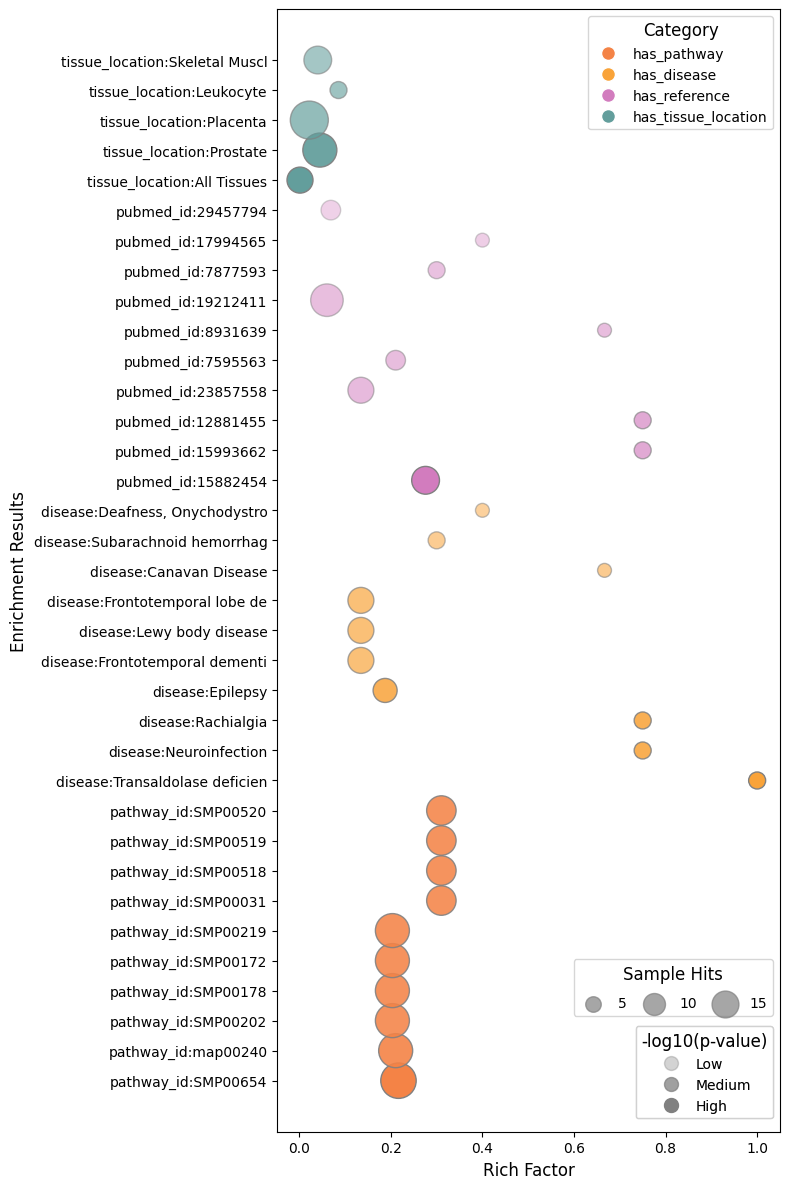

,Enrichment Results,P-Value,Total,Total Hits,Expected,Sample,Sample Hits,Rich Factor,Category,-Log10-p,Holm adjust,Reject Null Hypothesis,FDR,Q-Value
0,pathway_id:SMP00654,9.313187e-09,1024,60,1.992188,34,13,0.216667,has_pathway,8.030902,0.000452,True,0.000452,0.000452
5,pathway_id:map00240,5.891661e-08,1024,57,1.892578,34,12,0.210526,has_pathway,7.229762,0.002862,True,0.000493,0.000493
1,pathway_id:SMP00202,8.941258e-08,1024,59,1.958984,34,12,0.203390,has_pathway,7.048601,0.004343,True,0.000493,0.000493
2,pathway_id:SMP00178,8.941258e-08,1024,59,1.958984,34,12,0.203390,has_pathway,7.048601,0.004343,True,0.000493,0.000493
3,pathway_id:SMP00172,8.941258e-08,1024,59,1.958984,34,12,0.203390,has_pathway,7.048601,0.004343,True,0.000493,0.000493
4,pathway_id:SMP00219,8.941258e-08,1024,59,1.958984,34,12,0.203390,has_pathway,7.048601,0.004343,True,0.000493,0.000493
26,pathway_id:SMP00031,1.015851e-07,1024,29,0.962891,34,9,0.310345,has_pathway,6.993170,0.004934,True,0.000493,0.000493
31,pathway_id:SMP00518,1.015851e-07,1024,29,0.962891,34,9,0.310345,has_pathway,6.993170,0.004934,True,0.000493,0.000493
32,pathway_id:SMP00519,1.015851e-07,1024,29,0.962891,34,9,0.310345,has_pathway,6.993170,0.004934,True,0.000493,0.000493
35,pathway_id:SMP00520,1.015851e-07,1024,29,0.962891,34,9,0.310345,has_pathway,6.993170,0.004934,True,0.000493,0.000493


In [11]:
create_enrichment_plot(triples, hmdb_list, select_relations, num_relations_to_select)